In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from tqdm import tqdm
import scipy
import spiceypy as spice
import rebound
import reboundx
import matplotlib
import pandas as pd

In [13]:
import sys
sys.path.append('..')
from geminids.weights import *
from geminids.beta2mass import asteroidal as asteroidal
from geminids.constants import *

In [16]:
points_novel = []
points_vel = []
points_distr = []
n = 100
pth = "../output/"

for i in tqdm(range(n)):
    data = np.load(f'{pth}novel/particles{i}.npy')
    beta = np.load(f'{pth}novel/beta{i}.npy')
    size = np.load(f'{pth}novel/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(10000*100*2, 5)
    data = data[:,:3]
    
    
    
    points_novel.append(np.hstack((data, np.tile(size,20000).reshape(2000000,1), 
                                   np.tile(weight_novel(beta),20000).reshape(2000000,1))))
    
points_novel = np.array(points_novel)
points_novel = points_novel.reshape(2000000*n,5)

for i in tqdm(range( n)):
    data = np.load(f'{pth}vel/particles{i}.npy')
    beta = np.load(f'{pth}vel/beta{i}.npy')
    size = np.load(f'{pth}vel/mass{i}.npy')
    size = asteroidal(beta)
    data = data.reshape(10000*100*2, 5)
    data = data[:,:3]
    
    
    
    points_vel.append(np.hstack((data, np.tile(size,20000).reshape(2000000,1),
                                 np.tile(weight_vel(beta),20000).reshape(2000000,1))))
    
points_vel = np.array(points_vel)
points_vel = points_vel.reshape(2000000*n,5)
offset = 0
for i in tqdm(range(n*10)):
        try:
            data = np.load(f'{pth}distr/particles{i}.npy')
            beta = np.load(f'{pth}distr/beta{i}.npy')
            size = np.load(f'{pth}distr/mass{i}.npy')
            size = asteroidal(beta)
            data = data.reshape(10000*10*2, 5)
            data[data[:,4] < .2] *= 0
            data = data[:,:3]



            points_distr.append(np.hstack((data, np.tile(size,20000).reshape(200000,1), 
                                   np.tile(weight_distr(beta),20000).reshape(200000,1))))
        except Exception as e: 
            print(e)
            offset +=1
        
points_distr = np.array(points_distr)
points_distr = points_distr.reshape(200000*(n*10 - offset),5)
points_novel = points_novel[~np.isnan(points_novel).any(axis=1)]
points_vel = points_vel[~np.isnan(points_vel).any(axis=1)]
points_distr = points_distr[~np.isnan(points_distr).any(axis=1)]
points_distr = points_distr[points_distr[:,0] != 0]


orbit = np.load('../geminids/data/phaethon.npy')
psp2 = np.load('../geminids/data/psp.npy')
points_novel = points_novel[:,:5].copy()
points_vel = points_vel[:,:5].copy()
points_distr = points_distr[:,:5].copy()
orbit = orbit.reshape((20000,5))[:,:3].copy()
psp2 = psp2[:,:3].copy()


transform = spice.pxform("J2000", "ECLIPJ2000", 0)

print("Transforming")

points_novel[:,:3] = np.dot(transform, points_novel[:,:3].T).T
points_vel[:,:3] = np.dot(transform, points_vel[:,:3].T).T
points_distr[:,:3] = np.dot(transform, points_distr[:,:3].T).T
orbit = np.dot(transform, orbit.T).T
psp2 = np.dot(transform, psp2.T).T

  0%|          | 0/100 [00:00<?, ?it/s]../geminids/beta2mass.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  return a* x**-b
100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


In [18]:
# normalize to 1e18 g


masses = np.load("../cache/masses.npy")

norm_vel = masses[1] / np.sum(points_vel[:,3])
norm_novel = masses[0] / np.sum(points_novel[:,3])
norm_distr = masses[2] / np.sum(points_distr[:,3])

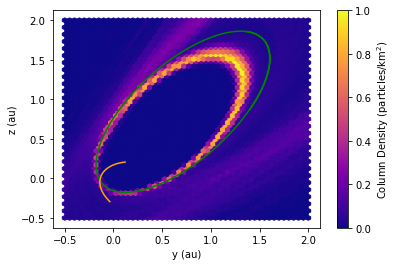

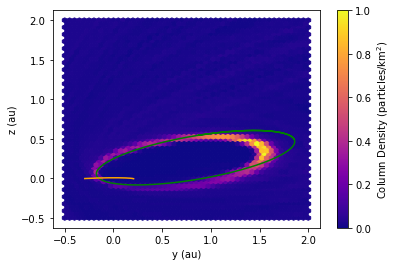

In [19]:
norm = norm_novel
grid=50

x = np.linspace(-.5, 2.5, grid*2)
y = np.linspace(-.5, 2.5, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_novel[:,0], nx.flatten())), np.hstack((points_novel[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_novel[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)






plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g', label = "Phaethon 3200")
plt.plot(psp2[:,0], psp2[:,1], c='orange', label = "Parker Solar Probe")

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.1.1.eps")
plt.show()



poly = plt.hexbin(np.hstack((points_novel[:,1], nx.flatten())), np.hstack((points_novel[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_novel[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# plt.clim(c_lim_2, c_max_2)




plt.colorbar(label = "Column Density (particles/km$^2$)")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.1.2.eps")
plt.show()

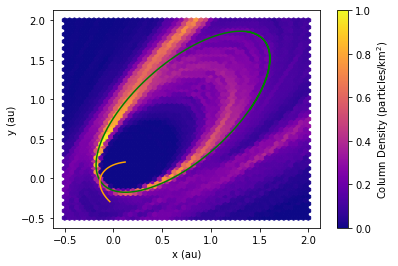

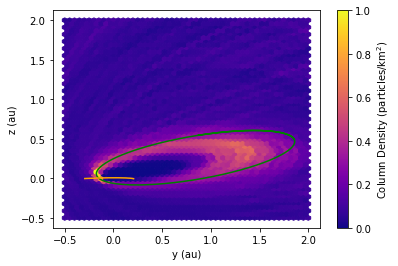

In [20]:
norm = norm_vel

x = np.linspace(-.5, 2.5, grid*2)
y = np.linspace(-.5, 2.5, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_vel[:,0], nx.flatten())), np.hstack((points_vel[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_vel[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize = grid)

# plt.clim(c_min_1, c_max_1)






plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g')
plt.plot(psp2[:,0], psp2[:,1], c='orange')

plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/Fig 1.2.1.eps")
plt.show()




poly = plt.hexbin(np.hstack((points_vel[:,1], nx.flatten())), np.hstack((points_vel[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_vel[:,4], c)),
                  reduce_C_function = np.sum)

plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize = grid)
# plt.clim(c_lim_2, c_max_2)





plt.colorbar(label = "Column Density (particles/km$^2$)")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.2.2.eps")

plt.show()

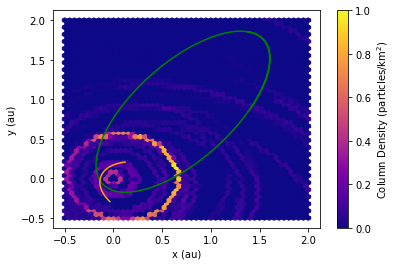

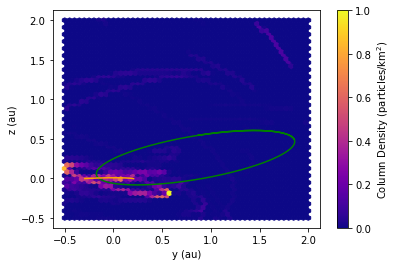

In [21]:
norm = norm_distr
grid = 50

x = np.linspace(-.5, 2.5, grid*2)
y = np.linspace(-.5, 2.5, grid*2)
c = np.zeros((grid*2)**2)
nx, ny = np.meshgrid(x, y)

poly = plt.hexbin(np.hstack((points_distr[:,0], nx.flatten())), np.hstack((points_distr[:,1], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_distr[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)

# plt.clim(c_min_1, c_max_1)






plt.colorbar(label = "Column Density (particles/km$^2$)")
plt.plot(orbit[:,0], orbit[:,1], alpha = 1, c='g')
plt.plot(psp2[:,0], psp2[:,1], c='orange')

plt.xlabel("x (au)")
plt.ylabel("y (au)")
plt.savefig("../figures/Fig 1.3.1.eps")
plt.show()







poly = plt.hexbin(np.hstack((points_distr[:,1], nx.flatten())), np.hstack((points_distr[:,2], ny.flatten())), cmap = "plasma", 
                  extent = (-.5,2.,-.5,2.), gridsize=grid, C = np.hstack((points_distr[:,4], c)),
                  reduce_C_function = np.sum)
plt.close()
offsets = poly.get_offsets()
C = poly.get_array()

dx = np.unique(np.sort(offsets, axis=0)[:,0])[1] - np.unique(np.sort(offsets, axis=0)[:,0])[0]
dy = np.unique(np.sort(offsets, axis=0)[:,1])[1] - np.unique(np.sort(offsets, axis=0)[:,1])[0]

V = 2*dx*dy*(au**2)/(1e3**2)

plt.hexbin(offsets[:,0], offsets[:,1], C=C/np.max(C), cmap="plasma", gridsize=grid)
# plt.clim(c_lim_2, c_max_2)





plt.colorbar(label = "Column Density (particles/km$^2$)")

plt.plot(orbit[:,1], orbit[:,2], alpha = 1, c='g')
plt.plot(psp2[:,1], psp2[:,2], c='orange')

plt.xlabel("y (au)")
plt.ylabel("z (au)")
plt.savefig("../figures/Fig 1.3.2.eps")
plt.show()